## Convolutional autoencoder version 01_08
From the previous explorations have decided to go with the following model (from 01_06):

* encoder = strided convolutions and batch normalizations
* decoder = strided transposed convlutions and batch normalization
* [batch normalization also after the final transposed convolution in the decoder]
* 'relu' activation
* no activation on the final output
* mse loss
* adam optimizer

Here I test the effect of different lengths for the latent representation. In 01_06 I was using 32, here I test either side of that: 16 and 64.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

In [3]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation, BatchNormalization
from keras.models import Model
from keras import backend as K

In [4]:
use_gpu = 'True'
if use_gpu == 'True':
    main_dir = '/scratch/LNP_data_01/'
else:
    main_dir = '/Users/phiha876/AZ/LNP/LNP_data_01/'

channels = [0] # 0=celltracker; 1=LNP; 2=BF
rescale_method = 'standardize'
batch_size = 32
input_img = Input(shape=(192, 192, len(channels)))
layer_filters = [16, 16, 32, 32] # number of filters for each layer
kernel_size = 3
latent_dim = 64
num_epochs = 30

train_dir = main_dir + 'training_data'
train_cell = glob.glob(train_dir + '/' '*')
validation_dir = main_dir + 'validation_data'
validation_cell = glob.glob(validation_dir + '/' '*')
stats = np.load('train_stats.npy')

In [5]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    ax = fig.add_subplot(122)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

In [6]:
def get_image(path, stats, rescale_method, channels):
    img = np.load(path)
    img = img[:, :, channels]
    if len(channels) == 1:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    if rescale_method == 'normalize':
        img = (img - stats[0, channels])/(stats[1, channels] - stats[0, channels])
    if rescale_method == 'standardize':
        img = (img - stats[2, channels])/stats[3, channels]
    img = img.astype('float32')
    return img

In [7]:
def rotate90xDegrees(img):
    ret =[]
    rows, cols = img.shape
    for i in range(1,4):
        M = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        ret.append(cv2.warpAffine(img,M,(cols,rows)))

    return ret

In [8]:
def augment_image(img, aug_no):
    img_new = np.zeros((img.shape)).astype('float32')
    rows, cols, chans = img.shape
    for i in range(chans):
        if aug_no == 0:
            img_new[:, :, i] = img[:, :, i]
        if aug_no == 1:
            img_new[:, :, i] = np.flipud(img[:, :, i])
        if aug_no == 2:
            img_new[:, :, i] = np.fliplr(img[:, :, i])
        if aug_no == 3:
            ud = np.flipud(img[:, :, i])
            img_new[:, :, i] = np.fliplr(ud)
        if aug_no == 4:
            img_new[:, :, i] = rotate90xDegrees(img[:, :, i])[0]
        if aug_no == 5:
            ud = np.flipud(img[:, :, i])
            img_new[:, :, i] = rotate90xDegrees(ud)[0]
        if aug_no == 6:
            lr = np.fliplr(img[:, :, i])
            img_new[:, :, i] = rotate90xDegrees(lr)[0]
        if aug_no == 7:
            ud = np.flipud(img[:, :, i])
            udlr = np.fliplr(ud)
            img_new[:, :, i] = rotate90xDegrees(udlr)[0]
    
    return img_new

In [9]:
def train_image_generator(files, batch_size, stats, rescale_method, channels):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths_in = np.random.choice(a = files, size = batch_size)
        # can later have out to be image at a future time point
        batch_paths_out = batch_paths_in
        batch_input = []
        batch_output = []
        aug_nums = np.random.randint(0, 8, batch_size)
        
        for ii, image_path in enumerate(batch_paths_in):
            img = get_image(image_path, stats=stats, rescale_method=rescale_method, channels=channels)
            aug_no = aug_nums[ii]
            img = augment_image(img, aug_no=aug_no)
            batch_input += [img]
        
        for ii, image_path in enumerate(batch_paths_in):
            img = get_image(image_path, stats=stats, rescale_method=rescale_method, channels=channels)
            aug_no = aug_nums[ii]
            img = augment_image(img, aug_no=aug_no)
            batch_output += [img]
        
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield batch_x, batch_y

In [10]:
def validation_image_generator(files, batch_size, stats, rescale_method, channels):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths_in = np.random.choice(a = files, size = batch_size)
        # can later have output paths to be image at a future time point
        batch_paths_out = batch_paths_in
        batch_input = []
        batch_output = []
        
        for image_path in batch_paths_in:
            img = get_image(image_path, stats=stats, rescale_method=rescale_method, channels=channels)
            batch_input += [img]
        
        for image_path in batch_paths_out:
            img = get_image(image_path, stats=stats, rescale_method=rescale_method, channels=channels)
            batch_output += [img]
        
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield batch_x, batch_y

(32, 192, 192, 1) (32, 192, 192, 1)


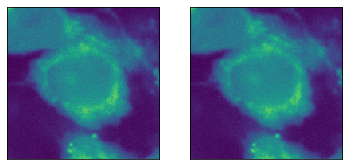

In [11]:
# test the image generator fn
for _ in train_image_generator(train_cell, batch_size, stats, rescale_method, channels):
    print(_[0].shape, _[1].shape)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(_[0][0, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(_[1][0, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    plt.close()
    break

(32, 192, 192, 1) (32, 192, 192, 1)


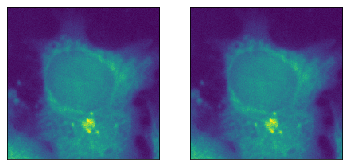

In [12]:
# test validation generator
for _ in validation_image_generator(validation_cell, batch_size, stats, rescale_method, channels):
    print(_[0].shape, _[1].shape)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(_[0][0, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(_[1][0, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    plt.close()
    break

In [13]:
def build_CAE(input_shape, layer_filters, kernel_size, latent_dim):
    x = input_shape
    for filters in layer_filters:
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    shape = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim)(x)
    encoder = Model(input_img, latent)
    
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    x = Conv2DTranspose(filters=1, kernel_size=kernel_size, padding='same')(x)
    outputs = BatchNormalization()(x)
    decoder = Model(latent_inputs, outputs)
    
    return encoder, decoder

In [14]:
encoder, decoder = build_CAE(input_img, layer_filters, kernel_size, latent_dim)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 16)        0         
__________

In [15]:
AE = Model(input_img, decoder(encoder(input_img)))
AE.compile(optimizer='adam', loss='mse')

## Results with a latent dim of 16

In [15]:
history = AE.fit_generator(
    train_image_generator(train_cell, batch_size, stats, rescale_method, channels),
    steps_per_epoch=len(train_cell) // batch_size,
    epochs = num_epochs,
    validation_data = validation_image_generator(validation_cell, batch_size, stats, rescale_method, channels),
    validation_steps = len(validation_cell) // batch_size
)

Epoch 1/30
688/688 [==============================] - 100s 145ms/step - loss: 0.3172 - val_loss: 0.1458
Epoch 2/30
688/688 [==============================] - 91s 132ms/step - loss: 0.2414 - val_loss: 0.1244
Epoch 3/30
688/688 [==============================] - 90s 131ms/step - loss: 0.2365 - val_loss: 0.1158
Epoch 4/30
688/688 [==============================] - 89s 129ms/step - loss: 0.2326 - val_loss: 0.1132
Epoch 5/30
688/688 [==============================] - 93s 135ms/step - loss: 0.2310 - val_loss: 0.1158
Epoch 6/30
688/688 [==============================] - 88s 128ms/step - loss: 0.2297 - val_loss: 0.1184
Epoch 7/30
688/688 [==============================] - 91s 132ms/step - loss: 0.2279 - val_loss: 0.1114
Epoch 8/30
688/688 [==============================] - 91s 133ms/step - loss: 0.2267 - val_loss: 0.1098
Epoch 9/30
688/688 [==============================] - 95s 138ms/step - loss: 0.2269 - val_loss: 0.1125
Epoch 10/30
688/688 [==============================] - 90s 131ms/step - 

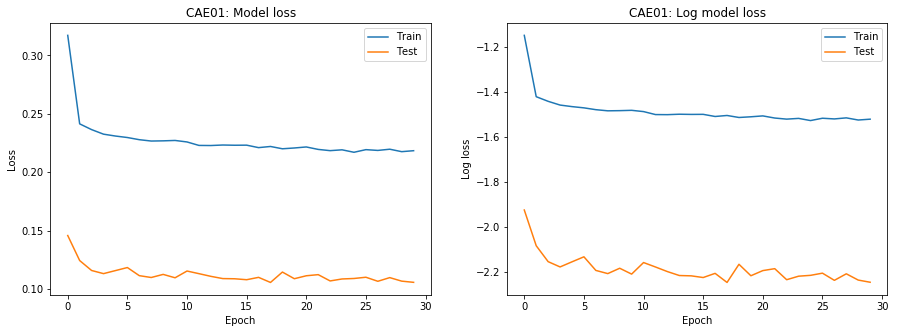

In [18]:
plot_history(history, 'CAE01')

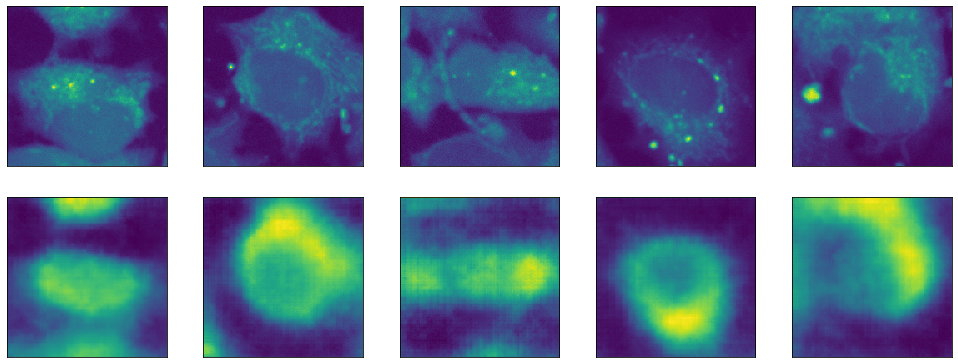

In [19]:
# display some original images and reconstructions
n = 5
plt.figure(figsize=(17, 17))

for jj in range(n):
    image_path = np.random.choice(a = validation_cell, size = 1)[0]
    img = get_image(image_path, stats=stats, rescale_method=rescale_method, channels=channels)
    orig_img = img[:, :, 0]
    ax = plt.subplot(n, n, jj + 1)
    plt.imshow(orig_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    orig_reshaped = orig_img.reshape(1, 192, 192, 1)
    encoded_img = encoder.predict(orig_reshaped)
    decoded_img = decoder.predict(encoded_img)
    ax = plt.subplot(n, n, jj + 1+ n)
    plt.imshow(decoded_img.reshape(192, 192))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Results with a latent dim of 64

In [16]:
history = AE.fit_generator(
    train_image_generator(train_cell, batch_size, stats, rescale_method, channels),
    steps_per_epoch=len(train_cell) // batch_size,
    epochs = num_epochs,
    validation_data = validation_image_generator(validation_cell, batch_size, stats, rescale_method, channels),
    validation_steps = len(validation_cell) // batch_size
)

Epoch 1/30
688/688 [==============================] - 103s 150ms/step - loss: 0.2117 - val_loss: 0.0742
Epoch 2/30
688/688 [==============================] - 98s 142ms/step - loss: 0.1185 - val_loss: 0.0606
Epoch 3/30
688/688 [==============================] - 98s 142ms/step - loss: 0.1136 - val_loss: 0.0589
Epoch 4/30
688/688 [==============================] - 91s 132ms/step - loss: 0.1109 - val_loss: 0.0575
Epoch 5/30
688/688 [==============================] - 96s 139ms/step - loss: 0.1100 - val_loss: 0.0550
Epoch 6/30
688/688 [==============================] - 96s 140ms/step - loss: 0.1085 - val_loss: 0.0549
Epoch 7/30
688/688 [==============================] - 95s 138ms/step - loss: 0.1070 - val_loss: 0.0541
Epoch 8/30
688/688 [==============================] - 97s 141ms/step - loss: 0.1066 - val_loss: 0.0564
Epoch 9/30
688/688 [==============================] - 94s 137ms/step - loss: 0.1055 - val_loss: 0.0516
Epoch 10/30
688/688 [==============================] - 93s 135ms/step - 

In [ ]:
plot_history(history, 'CAE01')

<p>
    <img src="CAE_01_08_64dim_history.png" alt="drawing" style="width:955px;"/>
    <center></center>
</p>

In [ ]:
# display some original images and reconstructions
n = 5
plt.figure(figsize=(17, 17))

for jj in range(n):
    image_path = np.random.choice(a = validation_cell, size = 1)[0]
    img = get_image(image_path, stats=stats, rescale_method=rescale_method, channels=channels)
    orig_img = img[:, :, 0]
    ax = plt.subplot(n, n, jj + 1)
    plt.imshow(orig_img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    orig_reshaped = orig_img.reshape(1, 192, 192, 1)
    encoded_img = encoder.predict(orig_reshaped)
    decoded_img = decoder.predict(encoded_img)
    ax = plt.subplot(n, n, jj + 1+ n)
    plt.imshow(decoded_img.reshape(192, 192))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<p>
    <img src="CAE_01_08_64dim_reconstructions.png" alt="drawing" style="width:955px;"/>
    <center></center>
</p>